In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, train_test_split

# Read in the CL data

In [5]:
# df = pd.read_csv('data/no_dupes_lda_fit5_18.csv')
# This has the latest preproc texts
df = pd.read_csv('5_22_preproc.csv')

# 0. Are titles alone predictive?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['listingTitle'], df['high_white'], random_state=0)

In [ ]:
word_vectorizer = CountVectorizer()
word_vectorizer.fit(X_train)
X_train_vectorized = word_vectorizer.transform(X_train)
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

# Not really.

# Read in neighborhood names

In [ ]:
with open('resources/hoods.txt', 'r') as inf:
    hoodnames = inf.read().splitlines()
    #hoodnames = inf.read()
    #hoodnames = re.split(r',\s*', hoodnames)

# Curated list of Seattle-area neighborhoods -- some manually added in.

In [ ]:
neighbs = """"'Adams' 'Alki' 'Arbor Heights' 'Atlantic' 'Ballard' 'Belltown' 'Bellevue' Bitter Lake'
 'Bothell' 'Bremerton' 'Briarcliff' 'Brighton' 'Broadview' 'Broadway' 'Bryant' 'Capitol Hill' 'Cedar Park'
 'Central Business District' 'Columbia City' 'Crown Hill' 'Dunlap'
 'East Queen Anne' 'Eastlake' 'Everett' 'Fairmount Park' 'Fauntleroy' 'Federal Way' 'First Hill'
 'Fremont' 'Gatewood' 'Genesee' 'Georgetown' 'Green Lake' 'Greenlake' 'Greenwood'
 'Haller Lake' 'Harrison/Denny-Blaine' 'High Point' 'Highland Park'
 'Holly Park' 'Industrial District' 'Interbay' 'International District' 'Issaquah' 'Kirkland'
 'Laurelhurst' 'Lawton Park' 'Leschi' 'Lower Queen Anne' 'Loyal Heights'
 'Madison Park' 'Madrona' 'Mann' 'Maple Leaf' 'Matthews Beach'
 'Meadowbrook' 'Mid-Beacon Hill' 'Mill Creek' Minor' 'Montlake' 'Mount Baker' 'Newcastle'
 'North Admiral' 'North Beach/Blue Ridge' 'North Beacon Hill'
 'North College Park' 'North Delridge' 'North Queen Anne' 'Olympic Hills'
 'Phinney Ridge' 'Pike-Market' 'Pinehurst' 'Pioneer Square' 'Portage Bay'
 'Rainier Beach' 'Ravenna' 'Redmond' 'Renton' 'Riverview' 'Roosevelt' 'Roxhill' 'Seaview'
 'Seward Park' 'Shoreline' 'South Beacon Hill' 'South Delridge' 'South Lake Union'
 'South Park' 'Southeast Magnolia' 'Stevens' 'Sunset Hill'
 'University District' 'U District' 'UDistrict' 'Victory Heights' 'View Ridge' 'Wallingford'
 'Wedgwood' 'West Seattle' 'West Queen Anne' 'West Woodland' 'Westlake'
 'Whittier Heights' 'Windermere' 'Yesler Terrace'""".split("'")

In [ ]:
hoods = [name.lower() for name in neighbs if re.match(r'\w+', name)]

In [ ]:
hoods

# Preprocess the data:
- Strip URLs (or.. should map them to '#url' ???)
- Map neighborhood names to '#hood'
- Tokenize words & punctuation


- don't use 'clean_text' yet since it has some preproc errors

In [ ]:
#url_pattern = r'(https?:\/\/)?(www)?.*[\r\n]*'


url_pattern = r'(http)?(www)?\S*(\.com|\.net|\.gov|\.be|\.org)\S*'

In [ ]:
punctuation_pattern = r"[#\w'-]+|[.,!?;]+"

In [ ]:
def preprocess(text):
    text = text.lower()
    no_urls = re.sub(url_pattern, '', text)
    for hood in hoodnames:
        # hood_pattern = r'\s+{0}\s+'.format(hood)
        #hood_pattern = r' ?'+hood+' ?'
        # Match neighborhood mentions surrounded by whitespace and replace with #hood
        no_urls = re.sub(r'\W+{0}\W+'.format(hood), ' #hood ', no_urls)
    no_digits = re.sub(r'\d+', '', no_urls)
    tokenized = re.findall(punctuation_pattern, no_digits)
    return ' '.join([word.lower() for word in tokenized])

In [ ]:
short_example = "this queen anne apartment is really cool !!! 98105 https://blah.com"

In [ ]:
long_example = df.loc[0]['body_text']

In [ ]:
preprocess(short_example)

In [ ]:
preprocess(long_example)

In [ ]:
texts = [[word for word in text.lower().split() if word not in hoodnames] for text in df.clean_text]

In [ ]:
# Apply preproc to all texts
df['preproc_text'] = df['body_text'].apply(preprocess)

In [ ]:
# Save her for faster loading!
df.to_csv('5_22_preproc.csv')

# Train & test models.
## Split the data into train & test sets
## First, binary classif: high white vs not

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_white'], random_state=0)

In [7]:
word_vectorizer = CountVectorizer()

In [20]:
X_train_vectorized = word_vectorizer.fit_transform(X_train)

In [21]:
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)

In [22]:
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]

In [23]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [24]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8558773412066003
F1 score:  0.8023227679651586
accuracy:  0.778410631950095


In [25]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

(0.0, 1.0)

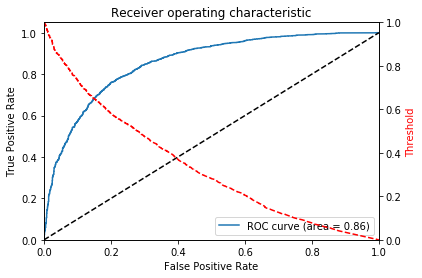

In [26]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [27]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['westwood' 'moda' 'rianna' 'marymoor' 'riverpark' 'mall' 'concierge'
 'sculpture' 'stadiums' 'harbor' 'fountain' 'airport' 'aurora' 'pools'
 'rail' 'baker' 'beacon' 'cleveland' 'exposed' 'olympus']

Largest Coefs: 
['foods' 'edwards' 'pearl' 'woodland' 'marq' 'cairns' 'sweeping'
 'inglenook' 'pinnacle' 'springline' 'urbana' 'esxpt' 'ivorywood'
 'northshore' 'locks' 'harvard' 'volunteer' 'waterscape' 'beach' 'nw']


In [28]:
# Five-fold cross validation
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_white']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    word_vectorizer.fit(X_train)
    X_train_vectorized = word_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(word_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()

    # Find the 10 smallest and 10 largest coefficients
    # The 10 largest coefficients are being indexed using [:-11:-1]
    # so the list returned is in order of largest to smallest
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

AUC:  0.839978492574239
F1 score:  0.7953420669577875
accuracy:  0.7616949152542373
Smallest Coefs:
['westwood' 'moda' 'mall' 'marymoor' 'riverpark' 'concierge' 'airport'
 'aurora' 'stadiums' 'pools' 'helios' 'sculpture' 'jefferson' 'rail'
 'baker' 'rianna' 'fountain' 'cleveland' 'cougar' 'beacon']

Largest Coefs: 
['works' 'foods' 'boutiques' 'zoo' 'marq' 'slu' 'odin' 'esxpt' 'woodland'
 'inglenook' 'springline' 'locks' 'northshore' 'pearl' 'waterscape'
 'beach' 'urbana' 'volunteer' 'harvard' 'nw']
AUC:  0.8195823479195576
F1 score:  0.7861987614273075
accuracy:  0.7542372881355932
Smallest Coefs:
['westwood' 'moda' 'rianna' 'mall' 'airport' 'marymoor' 'riverpark'
 'helios' 'aurora' 'baker' 'stadiums' 'sculpture' 'udr' 'concierge' 'rail'
 'jefferson' 'fountain' 'harbor' 'beacon' 'cleveland']

Largest Coefs: 
['woodland' 'village' 'foods' 'esxpt' 'cairns' 'marq' 'odin' 'springline'
 'pinnacle' 'locks' 'pearl' 'minor' 'summit' 'waterscape' 'volunteer'
 'urbana' 'beach' 'northshore' 'har

# Using ngram features

In [29]:
# remake train test split
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_white'], random_state=0)

In [30]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,4)).fit(X_train)

In [36]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
#model = LogisticRegression(C=.5).fit(X_train_ngrams, y_train)
model = LogisticRegression(C=.5, penalty='l2').fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]

In [37]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [38]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8852991886921033
F1 score:  0.8265700483091788
accuracy:  0.8052617304041226


In [39]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['mall' 'airport' 'south' 'rail' 'pool' 'concierge' 'major' 'westwood'
 'hood mall' 'shopping' 'light rail' 'marymoor' 'center' 'harbor steps'
 'hood university' 'gym' 'moda' 'club' 'marymoor park' 'south hood']

Largest Coefs: 
['children' 'point' 'basement' 'in home' 'st' 'hour fitness' 'whole foods'
 'square one' 'island square' 'hood ave' 'deck' 'hill' 'west' 'market'
 'hood village' 'shops' 'laundry' 'on hood' 'nw' 'beach']


In [40]:
# CV with ngram on high white
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_white']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_vectorized = ngram_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.5).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(ngram_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()

    # Find the 10 smallest and 10 largest coefficients
    # The 10 largest coefficients are being indexed using [:-11:-1]
    # so the list returned is in order of largest to smallest
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

AUC:  0.8583821968592805
F1 score:  0.8148997134670487
accuracy:  0.7810169491525424
Smallest Coefs:
['mall' 'south' 'rail' 'airport' 'pool' 'concierge' 'light rail'
 'hood mall' 'major' 'westwood' 'hood university' 'moda' 'center'
 'south hood' 'near' 'harbor steps' 'marymoor' 'aurora' 'playground'
 'shopping']

Largest Coefs: 
['island square' 'square one' 'basement' 'whole foods' 'volunteer'
 'classic' 'bars' 'locks' 'whole' 'laundry' 'hill' 'west' 'on hood'
 'hood village' 'hood ave' 'shops' 'deck' 'market' 'beach' 'nw']
AUC:  0.8464248091366118
F1 score:  0.8009395184967705
accuracy:  0.7701694915254237
Smallest Coefs:
['mall' 'airport' 'south' 'rail' 'pool' 'light rail' 'westwood'
 'hood university' 'concierge' 'near' 'cedar' 'gym' 'playground' 'major'
 'rianna' 'harbor steps' 'marymoor' 'freeways' 'center' 'club']

Largest Coefs: 
['woodland' 'smoking' 'basement' 'hood bedroom' 'northshore' 'laundry'
 'bike' 'summit' 'village' 'island square' 'cascade' 'deck' 'west'
 'hood ave' 

In [ ]:
# AP note (04/14) The neighborhood names are still not complete enough -_-
# also they are still sneaking in somehow... need more work on preproc
# 'kirkland' and 'issaquah' are IN the damn hoods list.. why are they still showing up?!
# 5/22: updated regex in preproc, does much better now!

# OK, that was a binary prediction on high-white; let's see high-black

In [47]:
# Prob a faster way to just grab new labels...
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_black'], random_state=0)

In [48]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
model = LogisticRegression(C=.5).fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]


#Parameters to try: l1 penalty instead of l2
# different regularization 

In [49]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [50]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8790716131303669
F1 score:  0.7527093596059113
accuracy:  0.7957689178193653


In [51]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['nw' 'ne' 'hood square' 'uw' 'school hood' 'trails' 'square' 'newport'
 'se' 'island' 'shops' 'hood park' 'beach' 'mountains' 'ne hood' 'ave nw'
 'zoo' 'trail' 'around' 'courtyard']

Largest Coefs: 
['rainier' 'fitness' 'section' 'golf course' 'hood station' 'cedar'
 'olive' 'concierge' 'apartment homes' 'harbor' 'golf' 'south hood'
 'pointe' 'valley' 'th ave hood wa' 'light rail' 'airport' 'th ave hood'
 'hood university' 'rail']


In [ ]:
X_train_vectorized = word_vectorizer.transform(X_train)
model = LogisticRegression(C=.1, penalty='l1').fit(X_train_vectorized, y_train)
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

In [ ]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

In [ ]:
y_test.value_counts()


In [ ]:
1627/2060

In [ ]:
# Try SVM..

model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
model.fit(X_train_vectorized,y_train)
predicted = model.predict(word_vectorizer.transform(X_test))
np.mean(predicted == y_test)

In [ ]:
model.score(word_vectorizer.transform(X_test), y_test)

In [ ]:
# Five-fold cross validation on unigrams
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_black']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    word_vectorizer.fit(X_train)
    X_train_vectorized = word_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.5).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(word_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

In [46]:
# CV with ngram
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_black']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_vectorized = ngram_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.5).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(ngram_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

AUC:  0.8570017743120733
F1 score:  0.7233669443226654
accuracy:  0.7861016949152543
Smallest Coefs:
['nw' 'ne' 'hood square' 'uw' 'trails' 'newport' 'se' 'school hood'
 'mountains' 'beach' 'shops' 'hood park' 'trail' 'ave nw' 'courtyard'
 'square' 'ne hood wa' 'tour today' 'zoo' 'excellent']

Largest Coefs: 
['flooring' 'elliott' 'mall' 'moda' 'olive' 'hood station' 'ave hood'
 'harbor' 'pointe' 'th ave hood wa' 'south hood' 'golf' 'station'
 'th ave hood' 'concierge' 'court' 'light rail' 'airport'
 'hood university' 'rail']
AUC:  0.860598941466387
F1 score:  0.7143507972665147
accuracy:  0.7874576271186441
Smallest Coefs:
['nw' 'ne' 'uw' 'hood square' 'trails' 'school hood' 'hood park' 'se'
 'shops' 'beach' 'island' 'newport' 'square' 'ave nw' 'mountains' 'nw th'
 'zoo' 'starting' 'ne hood' 'trail']

Largest Coefs: 
['hood airport' 'south' 'golf course' 'the hood hood' 'community college'
 'valley' 'ave hood' 'olive' 'concierge' 'court' 'south hood'
 'hood station' 'station' 'pointe'